The goal of this first practical session is to introduce computational optimal transport (OT) in Python. You will familiarize yourself with OT by:
1. Computing exact optimal transport, using the Python library `POT` (Python Optimal Transport).
2. Computing entropic optimal transport, using first your own version of the Sinkhorn algorithm, then the Python library `OTT` (Optimal Transport Tools).

# 0. Plotters

In order to lighten the reading of the notebook, we place the functions allowing to perform plots, that are used multiple times, in the section below.

In [1]:
def plot_weighted_points(
    ax,
    X, a,
    Y, b,
    title=None, X_label=None, Y_label=None
):
  ax.scatter(X[:,0], X[:,1], s=5000*a, c='r', edgecolors='k', label=X_label)
  ax.scatter(Y[:,0], Y[:,1], s=5000*b, c='b', edgecolors='k', label=Y_label)
  for i in range(np.shape(X)[0]):
      ax.annotate(str(i+1), (X[i,0], X[i,1]),fontsize=30,color='black')
  for i in range(np.shape(Y)[0]):
      ax.annotate(str(i+1), (Y[i,0], Y[i,1]),fontsize=30,color='black')
  if X_label is not None or Y_label is not None:
    ax.legend(fontsize=20)
  ax.axis('off')
  ax.set_title(title, fontsize=25)

def plot_assignement(
    ax,
    X, a,
    Y, b,
    optimal_plan,
    title=None, X_label=None, Y_label=None
):
  plot_weighted_points(
    ax=ax,
    X=X, a=a,
    Y=Y, b=b,
    title=None,
    X_label=X_label, Y_label=Y_label
  )
  for i in range(optimal_plan.shape[0]):
      for j in range(optimal_plan.shape[1]):
          ax.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], c='k', lw=30*optimal_plan[i,j], alpha=0.8)
  ax.axis('off')
  ax.set_title(title, fontsize=30)

def plot_assignement_1D(
    ax,
    X, Y,
    title=None
):
  plot_points_1D(
    ax,
    X, Y,
    title=None
  )
  X_sorted = np.sort(X)
  Y_sorted = np.sort(Y)
  assert len(X) == len(Y), "X and Y must have the same shape."
  for i in range(len(X)):
    ax.hlines(
        y=0,
        xmin=min(X_sorted[i], Y_sorted[i]),
        xmax=max(X_sorted[i], Y_sorted[i]),
        color='k',
        lw=10
    )
  ax.axis('off')
  ax.set_title(title, fontsize=30)

def plot_points_1D(
    ax,
    X, Y,
    title=None
):
  n = len(X)
  a = np.ones(n) / n
  ax.scatter(X, np.zeros(n), s=1000*a, c='r')
  ax.scatter(Y, np.zeros(n), s=1000*b, c='b')
  min_val = min(np.min(X), np.min(Y))
  max_val = max(np.max(X), np.max(Y))
  for i in range(n):
      ax.annotate(str(i+1), xy=(X[i], 0.005), size=30, color='r', ha='center')
  for j in range(n):
      ax.annotate(str(j+1), xy=(Y[j], 0.005), size=30, color='b', ha='center')
  ax.axis('off')
  ax.plot(np.linspace(min_val, max_val, 10), np.zeros(10))
  ax.set_title(title, fontsize=30)

def plot_consistency(
    ax,
    reg_strengths,
    plan_diff, distance_diff
):
  ax[0].loglog(reg_strengths, plan_diff, lw=4)
  ax[0].set_ylabel('$||P^* - P_\epsilon^*||_F$', fontsize=25)
  ax[1].tick_params(which='both', size=20)
  ax[0].grid(ls='--')
  ax[1].loglog(reg_strengths, distance_diff, lw=4)
  ax[1].set_xlabel('Regularization Strength $\epsilon$', fontsize=25)
  ax[1].set_ylabel(r'$ 100 \cdot \frac{\langle C, P^*_\epsilon \rangle - \langle C, P^* \rangle}{\langle C, P^* \rangle} $', fontsize=25)
  ax[1].tick_params(which='both', size=20)
  ax[1].grid(ls='--')

# I: Exact Optimal Transport with POT

## I.1 Reminders on Discrete Optimal Transport

Optimal Transport is a theory that allows us to compare two (weighted) points clouds $(X, a)$ and $(Y, b)$, where $X \in \mathbb{R}^{n \times d}$ and $Y \in \mathbb{R}^{m \times d}$ are the locations of the $n$ (resp. $m$) points in dimension $d$, and $a \in \mathbb{R}^n$, $b \in \mathbb{R}^m$ are the weights. We ask that the total weights sum to one, i.e. $\sum_{i=1}^n a_i = \sum_{j=1}^m b_j = 1$.

The basic idea of Optimal Transport is to "transport" the mass located at points $X$ to the mass located at points $Y$.

Let us denote by $U(a,b) := \left\{ P \in \mathbb{R}^{n \times m} \,|\, P \geq 0, \sum_{j=1}^m P_{ij} = a_i, \sum_{i=1}^n P_{ij} = b_j\right\}$ the set of admissible transport plans.

If $P \in U(a,b)$, the quantity $P_{ij} \geq 0$ should be regarded as the mass transported from point $X_i$ to point $Y_j$. For this reason, it is called a *transport plan*.

We will also consider a *cost function* $c : \mathbb{R}^d \times \mathbb{R}^d → \mathbb{R}$ and the associated cost matrix $C = [c(X_i, Y_j)]_{1\leq i,j \leq n,m}\in \mathbb{R}^{n \times m}$, containing the pairwise costs between the points of each point cloud $X$ and $Y$. The quantity $C_{ij}$ should be regarded as the cost paid for transporting one unit of mass from $X_i$ to $Y_j$. This cost is usually computed using the positions $X_i$ and $Y_j$, for example $C_{ij} = \|X_i - Y_j\|_2$ or $C_{ij} = \|X_i - Y_j\|_2^2$, but may be more exotic in some cases.

Then transporting mass according to $P \in U(a,b)$ has a total cost of $\sum_{i,j=1}^n P_{ij} C_{ij}$.

In "Optimal Transport", there is the word _Optimal_. Indeed, we want to find a transport plan $P \in U(a,b)$ that will minimize its total cost. In other words, we want to solve
$$
    \min_{P \in U(a,b)} \sum_{i,j=1}^n C_{ij }P_{ij} = \min_{P \in U(a,b)} ⟨C, P⟩.
$$

This problem is a Linear Program: the objective function is linear in the variable $P$, and the constraints are linear in $P$. We can thus solve this problem using classical Linear Programming algorithms, such as the simplex algorithm.

If $P^*$ is a solution to the Optimal Transport problem, we will say that $P^*$ is an optimal transport plan between $(X, a)$ and $(Y, b)$, and that $\sum_{ij} P^*_{ij} C_{ij}$ is the optimal transport distance between $(X, a)$ and $(Y, b)$: it is the minimal amount of "energy" that is necessary to transport the initial mass located at points $X$ to the target mass lcoated at points $Y$.

Usually, we represent the weighted point clouds by probability measures $\mu = \sum_{i=1}^n a_i \delta_{X_i}$ and $\nu = \sum_{j=1}^m b_j \delta_{Y_j}$. Solving the above problem, we then say that we solve the optimal transport problem between the measures $\mu$ and $\nu$. Moreover, we note:
$$
W_c(\mu, \nu) = \min_{P \in U(a,b)} ⟨C, P⟩.
$$

## I.2 Computing Optimal "Croissant" Transport

### Install POT

First, you need to install the package POT:

In [2]:
# ! pip install POT

Then, load the required packages.

In [3]:
import ot
import numpy as np
import os
from typing import Callable
import matplotlib.pyplot as plt

Finally, connect the notebok to your drive to load some data that will be used for the experiments.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/TP_OT")

### Formalization of the problem

We will solve the Bakeries/Cafés problem of transporting croissants from a number of Bakeries to Cafés.

We use fictional positions, production and sale numbers. We impose that the total croissant production is equal to the number of croissants sold, so that Bakeries and Cafés can be represented as measures with the same total mass. Then, up to normalization, they can be processed as probability measures.

Mathematically, we have acess to the position of the $m$ Bakeries as points in $\mathbb{R}^2$ via $X \in \mathbb{R}^{n \times 2}$ and their respective production via $a \in \mathbb{R}^m$ which describe the source point cloud. The Cafés where the croissants are sold are also defined by their position $Y \in \mathbb{R}^{m \times 2}$ and the quantity of croissants sold by $b \in \mathbb{R}^{m}$.

Afterwards, the Bakeries are represented by the probability measure $\mu = \sum_{i=1}^n a_i \delta_{x_i}$ and the Cafés by $\nu = \sum_{j=1}^n b_j \delta_{y_j}$. Calculating the optimal assignment of the croissants delivered by the Bakeries to the Cafés remains to calculating the optimal transport between the probability measures $\mu$ and $\nu$.

Let's download the data and check that the total croissant production is equal to the number of croissants sold.

In [5]:
# Load the data
import pickle

with open('data/croissants.pickle', 'rb') as file:
    croissants = pickle.load(file)

from urllib.request import urlopen
# import cloudpickle as cp

# croissants = cp.load(urlopen('https://marcocuturi.net/data/croissants.pickle'))

bakery_pos = croissants['bakery_pos']
bakery_prod = croissants['bakery_prod']
cafe_pos = croissants['cafe_pos']
cafe_prod = croissants['cafe_prod']

print('Bakery productions =', bakery_prod)
print('Total number of croissants =', bakery_prod.sum())
print("")
print('Café sales =', cafe_prod)
print('Total number of croissants sold =', cafe_prod.sum())

Bakery productions = [31. 48. 82. 30. 40. 48. 89. 73.]
Total number of croissants = 441.0

Café sales = [82. 88. 92. 88. 91.]
Total number of croissants sold = 441.0


We now normalize the weight vectors $a$ and $b$, i.e. the production and the sales, to deal with probability measures.

In [6]:
bakery_prod = bakery_prod / bakery_prod.sum()
cafe_prod = cafe_prod / cafe_prod.sum()

Then, we plot the probability measures (the weighted point clouds) in $\mathbb{R}^2$.

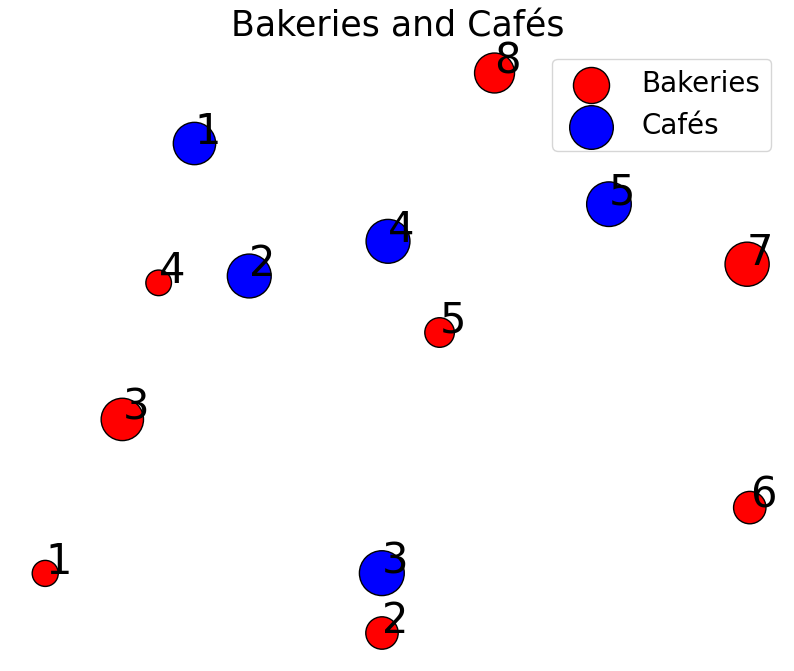

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_weighted_points(
    ax,
    X=bakery_pos,
    a=bakery_prod,
    X_label="Bakeries",
    Y=cafe_pos,
    Y_label="Cafés",
    b=cafe_prod,
    title="Bakeries and Cafés"
)
plt.show()

### Solving the problem


To compute the optimal transport, we will consider three different costs:
* $\ell_1$: $c(x, y) = \|x - y\|_1$ ,
* $\ell_2$: $c(x, y) = \|x - y\|_2$,
* $\ell_2^2$: $c(x, y) = \|x - y\|_2^2$.

Note that for different costs, there is a priori no reason to obtain the same optimal transport plan.

***
**Question:**
 * Complete the following function that computes a cost matrix $C$ from two set of points $X, Y$ and a cost function $c$. Compute the three costs matrices $C_{\ell_1}, C_{\ell_2}, C_{\ell_2^2}\in \mathbb{R}^{n \times m}$ using that function.
 * What cost should be used to minimize the total distance traveled by the driver that delivers croissants from Bakeries to Cafés?  
  $\sum_{i\in[n+m-1]} l(z_{i+1}-z_{i}) u.c. \forall i\in[n+m], \sum_{i\leq j} s_j \geq 0$ (something like TSP with stock positivity constraint)

**Answer:**

In [8]:
def get_differences(X,Y):
    n = X.shape[0]
    m = Y.shape[0]
    differences = X[:,None,...] - Y[None,:,...]
    # assert differences.shape == (n,m,2), f"Expected shape {(n,m,2)}, got {differences.shape}"
    return differences

def get_cost_matrix(
    X: np.ndarray,
    Y: np.ndarray,
    cost_fn: Callable
) -> np.ndarray:
  """
  Compute the pairwise cost matrix between the n points in ``X`` and the m points in ``Y``.
  It should output a matrix of size n x m.
  """
  n = X.shape[0]
  differences = get_differences(X,Y)
  cost_matrix = cost_fn(differences)
  return cost_matrix


# compute cost matrices for different costs
def l1(x):
    if x.ndim > 2:
        return np.sum(abs(x),axis=-1)
    else:
        return abs(x)
      
C_l1 = get_cost_matrix(
    X=bakery_pos, Y=cafe_pos,
    cost_fn=l1
  )

def l2(x):
    if x.ndim > 2:
        return np.linalg.norm(x,axis=-1)
    else:
        return l1(x)
C_l2 = get_cost_matrix(
    X=bakery_pos, Y=cafe_pos,
    cost_fn= l2
)

def l2_sq(x):
    if x.ndim > 2:
        return np.linalg.norm(x,axis=-1)**2
    else:
        return l1(x)**2
    
C_l2_sq = get_cost_matrix(
    X=bakery_pos, Y=cafe_pos,
    cost_fn=l2_sq
)

# print shapes of cost matrices
print(
    f"Shape of C_l1: {C_l1.shape}\n"
    f"Shape of C_l2: {C_l2.shape}\n"
    f"Shape of C_l2_sq: {C_l2_sq.shape}"
)

Shape of C_l1: (8, 5)
Shape of C_l2: (8, 5)
Shape of C_l2_sq: (8, 5)


***

We can now compute the Optimal Transport plan to transport the croissants from the bakeries to the cafés, for the three different costs.


***
**Question:**
* Complete the following fuction that takes as input the cost matrix $C$ and the weights vectors $a$ and $b$ and outputs the optimal transport plan and the optimal transport cost using the `ot.emd` function. It has an option to display the results.
* Use that function to compute and display the optimal plan and the optimal cost for $\ell_1, \ell_2$ and $\ell_2^2$ geometries.

**Remark:** See https://pythonot.github.io/ for informations on the `ot.emd` function.

**Answer:**

In [14]:
def compute_transport(
    C: np.ndarray,
    a: np.ndarray,
    b: np.ndarray,
    verbose: bool = False,
):
  """
  Compute the optimal transport plan and the optimal transport cost
  for cost matrix ``C`` and weight vectors $a$ and $b$.
  If ``verbose`` is set to True, it displays the results.
  """
  optimal_plan = ot.emd(a, b, C)
  optimal_cost = np.sum(optimal_plan * C)
    
  if verbose:
    print(
        f"optimal transport plan: \n{optimal_plan}"
    )
    print(
        f"transport cost: {optimal_cost}"
    )
    # ot.plot.plot2D_samples_mat(a,b,optimal_plan)
  return optimal_plan, optimal_cost

In [15]:
# l1 geometry
print("l1 geometry:")
optimal_plan_l1_croissant, optimal_cost_l1_croissant = compute_transport(
    C=C_l1,
    a=bakery_prod,
    b=cafe_prod,
    verbose=True
)

l1 geometry:
optimal transport plan: 
[[0.07029478 0.         0.         0.         0.        ]
 [0.         0.         0.10884354 0.         0.        ]
 [0.05442177 0.13151927 0.         0.         0.        ]
 [0.         0.06802721 0.         0.         0.        ]
 [0.         0.         0.         0.09070295 0.        ]
 [0.         0.         0.09977324 0.00453515 0.00453515]
 [0.         0.         0.         0.         0.20181406]
 [0.06122449 0.         0.         0.10430839 0.        ]]
transport cost: 177.28420815406028


In [16]:
# l2 geometry
print("l2 geometry:")
optimal_plan_l2_croissant, optimal_cost_l2_croissant = compute_transport(
    C=C_l2,
    a=bakery_prod,
    b=cafe_prod,
    verbose=True
)

l2 geometry:
optimal transport plan: 
[[0.         0.07029478 0.         0.         0.        ]
 [0.         0.         0.10884354 0.         0.        ]
 [0.05668934 0.1292517  0.         0.         0.        ]
 [0.06802721 0.         0.         0.         0.        ]
 [0.         0.         0.         0.09070295 0.        ]
 [0.         0.         0.09977324 0.00453515 0.00453515]
 [0.         0.         0.         0.         0.20181406]
 [0.06122449 0.         0.         0.10430839 0.        ]]
transport cost: 139.50829866844097


In [17]:
# squared l2 geometry
print("squared l2 geometry:")
optimal_plan_l2_sq_croissant, optimal_cost_l2_sq_croissant = compute_transport(
    C=C_l2_sq,
    a=bakery_prod,
    b=cafe_prod,
    verbose=True
)

squared l2 geometry:
optimal transport plan: 
[[0.         0.07029478 0.         0.         0.        ]
 [0.         0.         0.10884354 0.         0.        ]
 [0.11791383 0.06802721 0.         0.         0.        ]
 [0.06802721 0.         0.         0.         0.        ]
 [0.         0.06122449 0.         0.02947846 0.        ]
 [0.         0.         0.09977324 0.00453515 0.00453515]
 [0.         0.         0.         0.         0.20181406]
 [0.         0.         0.         0.16553288 0.        ]]
transport cost: 24576.370543882174


***

Now, we can visualize the assignement induced by each geometry.

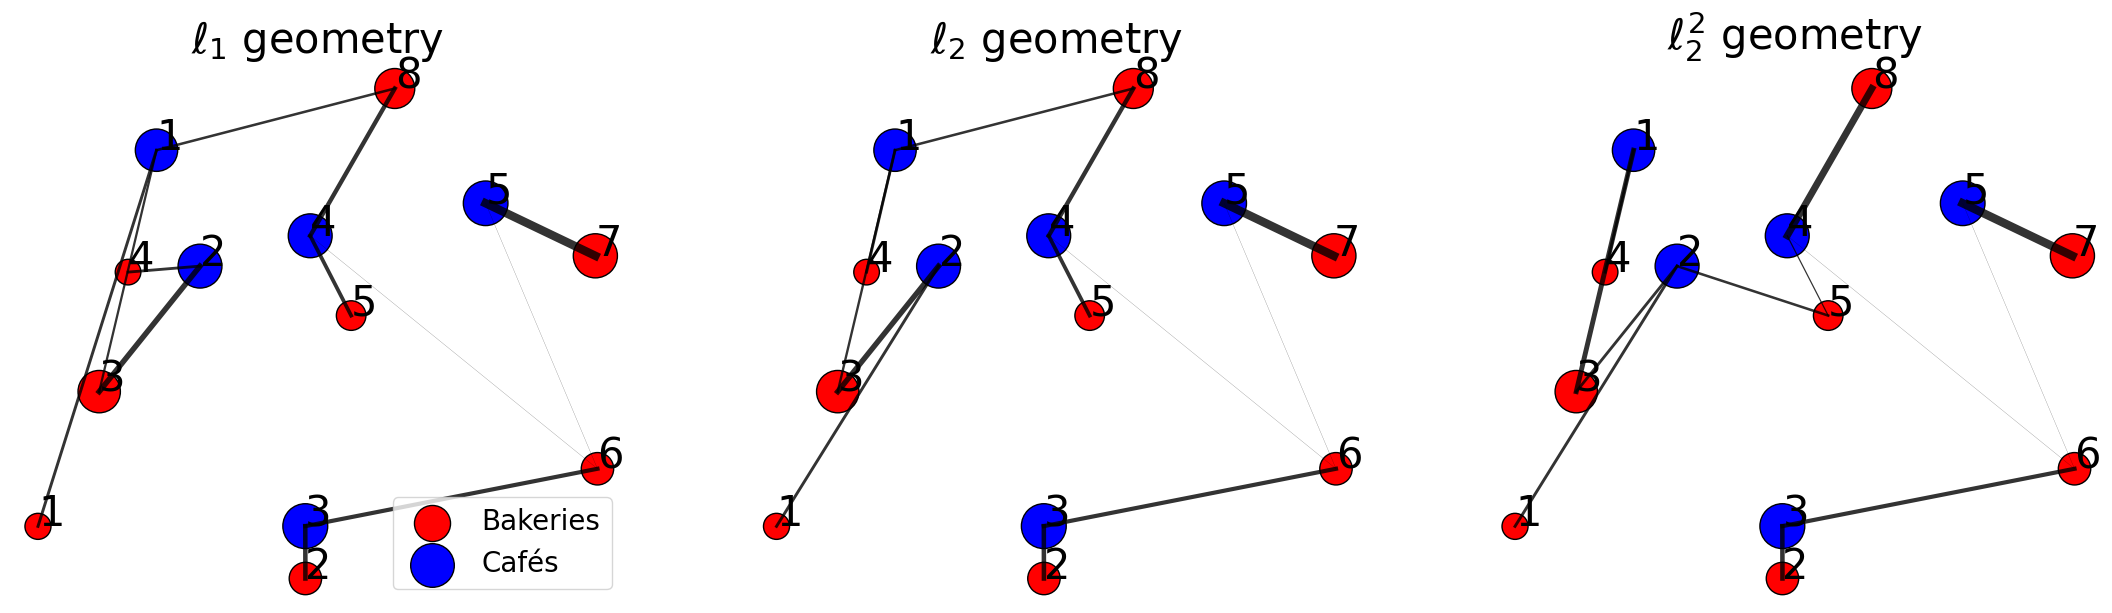

In [18]:
fig, ax = plt.subplots(
    1, 3, figsize=(9*3, 7)
)

plot_assignement(
    ax=ax[0],
    X=bakery_pos, a=bakery_prod, X_label="Bakeries",
    Y=cafe_pos, b=cafe_prod, Y_label="Cafés",
    optimal_plan=optimal_plan_l1_croissant,
    title=r"$\ell_1$ geometry"
)

plot_assignement(
    ax=ax[1],
    X=bakery_pos, a=bakery_prod,
    Y=cafe_pos, b=cafe_prod,
    optimal_plan=optimal_plan_l2_croissant,
    title=r"$\ell_2$ geometry"
)

plot_assignement(
    ax=ax[2],
    X=bakery_pos, a=bakery_prod,
    Y=cafe_pos, b=cafe_prod,
    optimal_plan=optimal_plan_l2_sq_croissant,
    title=r"$\ell_2^2$ geometry"
)

plt.show()

## I.3 Discrete OT plans between uniform measures are permutations

### Reminders on OT and Birkhoff Theorem
Now let's assume that we handle uniform weighted point clouds supported on the same number of points. Thus, keeping the previous notations, $(X, a)$ and $(Y, b)$ with $a = b = \frac{1}{n} \mathrm{1}$ and $X, Y \in \mathbb{R}^{n \times d}$ i.e. $n=m$. Therefore, $\mu = \frac{1}{n} \sum_{i=1}^n \delta_{X_i}$ and $\nu = \frac{1}{n} \sum_{i=1}^n \delta_{Y_i}$. In that case, one can show the optimal transport plan $P^*$ between $\mu$ and $\nu$ is a permutation, i.e. for each atom $x_i$ of $\mu$, its whole $\frac{1}{n}$ mass is tranfered to an atom $y_{\sigma(i)}$ of $\nu$. There is no mass splitting.

Indeed, let's first note that the set of admissible transport plans is:
$$
U_n := U(\frac{1}{n}\mathrm{1}, \frac{1}{n}\mathrm{1}) = \{
P \in \mathbb{R}^{n \times n}, P \geq 0, P \mathrm{1} = \frac{1}{n}\mathrm{1}, P^\top \mathrm{1} = \frac{1}{n} \mathrm{1}
\}
$$
so $U_n$ is the set of bistochatic matrices, whose rows and columns sum to $\frac{1}{n}$. If we define the permutation matrices by:
$$
\mathrm{Perm}(n) := \{
P \in \mathbb{R}^{n \times n}, ∃ \sigma \in \mathcal{S}_n, P_{ij} = \frac{1}{n} \delta_{j\sigma(i)}
\}
$$
one has $\mathrm{Perm}(n) \subset U_n$. In addition, thanks to the Birkhoff Theorem, the set of extremal points of the bistochastic matrices are the permutation matrices, i.e. $\mathrm{Ext}(U_n) = \mathrm{Perm}(n)$. Since the optimal value of a linear program is always attained on an extremal point of the constainted set, one has:
$$
W_c(\mu, \nu) = \min_{P\in U_n} \sum_{i,j=1}^n P_{ij}C_{ij} = \min_{P\in \mathrm{Perm}(n)} \sum_{i,j=1}^n P_{ij}C_{ij} = \min_{\sigma \in \mathcal{S}_n} \frac{1}{n} \sum_{i=1}^n C_{i \sigma(i)}
$$
Therefore, if $P^*$ is the optimal transport plan between $\mu$ and $\nu$, there exists $\sigma^* \in \mathcal{S}_n$ such that $P^* = P_{\sigma^*}$ and:
$$
\frac{1}{n} \sum_{i=1}^n c(X_i, Y_{\sigma^*(i)}) = \min_{\sigma \in \mathcal{S}_n} \frac{1}{n} \sum_{i=1}^n c(X_i, Y_{\sigma(i)})
$$

In this section, we will illustrate this fact for $d = 2$, then for $d = 1$ by linking optimal transport and sorting.


### In dimension $d = 2$

In [19]:
# Generate uniform weighted point clouds
n, d = 10, 2
np.random.seed(42)
X = np.random.uniform(low=0.5, high=1., size=(n, d))
Y = np.random.uniform(low=0., high=.5, size=(n, d))
a = np.ones(n) / n
b = np.ones(n) / n

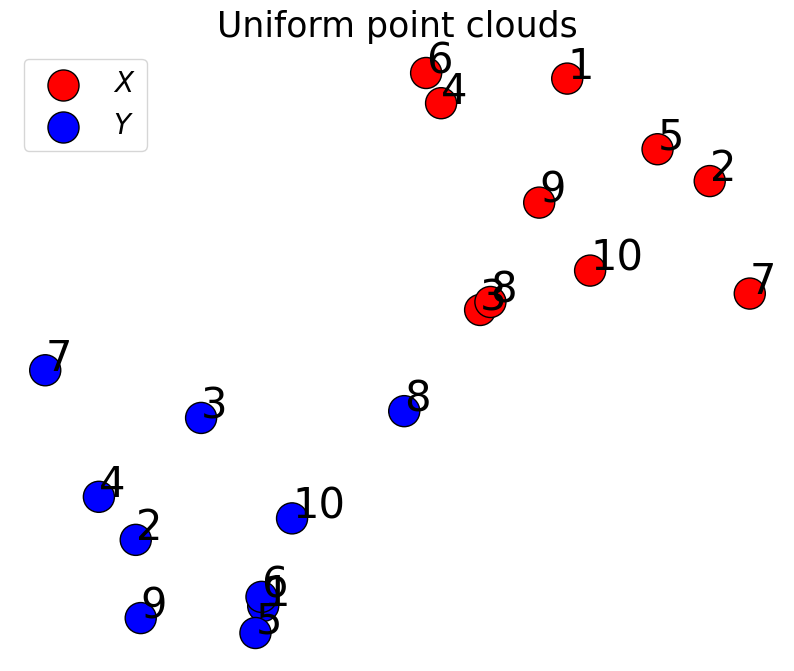

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_weighted_points(
    ax,
    X=X,
    a=a,
    X_label=r"$X$",
    Y=Y,
    Y_label=r"$Y$",
    b=b,
    title="Uniform point clouds"
)
plt.show()

optimal transport plan: 
[[0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]]
transport cost: 0.7154539344580824


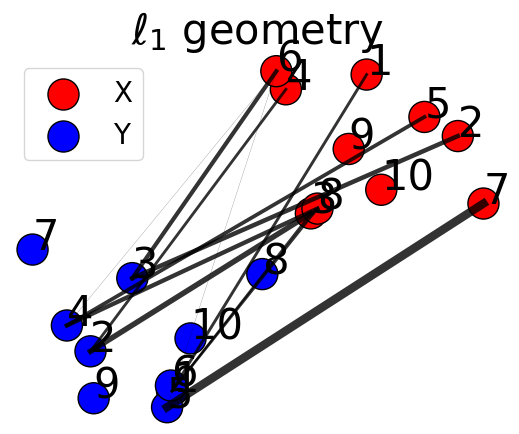

In [21]:
# l1 geometry
C_l2 = get_cost_matrix(
    X=X, Y=Y,
    cost_fn= lambda x: np.linalg.norm(x,axis=-1)
)
optimal_plan_l2, optimal_cost_l1_croissant = compute_transport(
    C=C_l2,
    a=a,
    b=b,
    verbose=True
)
plot_assignement(
    ax=plt.gca(),
    X=X, a=a, X_label="X",
    Y=Y, b=b, Y_label="Y",
    optimal_plan=optimal_plan_l1_croissant,
    title=r"$\ell_1$ geometry"
)

***
**Question:**
* Using the code from the section I.2, compute and display the optimal plan and the optimal cost for $\ell_1, \ell_2$ and $\ell_2^2$ geometries.
* Verify that the optimal plans are permutation matrices.

**Answer:**

In [22]:
def is_permutation(transport_plan: np.ndarray):
  """
  Test whether a transport plan between uniform measures supported on the same number of points is a permutation matrix.
  Since it satisfies the marginal constraints, it remains to test if the entries are in [0, 1/n].
  """
  assert np.all(transport_plan >= 0), (
      "A transport plan should have nonnegative entries."
  )
  assert (transport_plan.shape[0] == transport_plan.shape[1]) and transport_plan.ndim == 2, (
      "A transport plan which is not a square matrix cannot be a permutation matrix."
  )
    
  n = transport_plan.shape[0]
  unif = np.ones(n) / n
  assert (
      np.all(np.sum(transport_plan,axis=0)==unif)
      and
      np.all(np.sum(transport_plan,axis=1)==unif)
  ), (
      "A transport plan between uniform measures should verify the uniform marginal constraints."
  )
  return (
      np.all(np.isin(transport_plan, [0.,1/n]))
  )

In [23]:
# l1 geometry
print("l1 geometry:")
C_l1 = get_cost_matrix(X,Y,l1)
optimal_plan_l1, optimal_cost_l1 = compute_transport(
    C=C_l1,
    a=a,
    b=b,
    verbose=False
)

print(
    f"is permutation matrix? {is_permutation(optimal_plan_l1)}"
)

l1 geometry:
is permutation matrix? True


In [24]:
# l2 geometry
print("l2 geometry:")
C_l2 = get_cost_matrix(X,Y,l2)
optimal_plan_l2, optimal_cost_l2 = compute_transport(
    C=C_l2,
    a=a,
    b=b,
    verbose=False
)

print(
    f"is permutation matrix? {is_permutation(optimal_plan_l2)}"
)

l2 geometry:
is permutation matrix? True


In [25]:
# squared l2 geometry
C_l2_sq = get_cost_matrix(X,Y,l2_sq)
optimal_plan_l2_sq, optimal_cost_l2_sq = compute_transport(
    C=C_l2_sq,
    a=a,
    b=b,
    verbose=False
)

print(
    f"is permutation matrix? {is_permutation(optimal_plan_l2_sq)}"
)

is permutation matrix? True


***

We can now plot the optimal assignements.

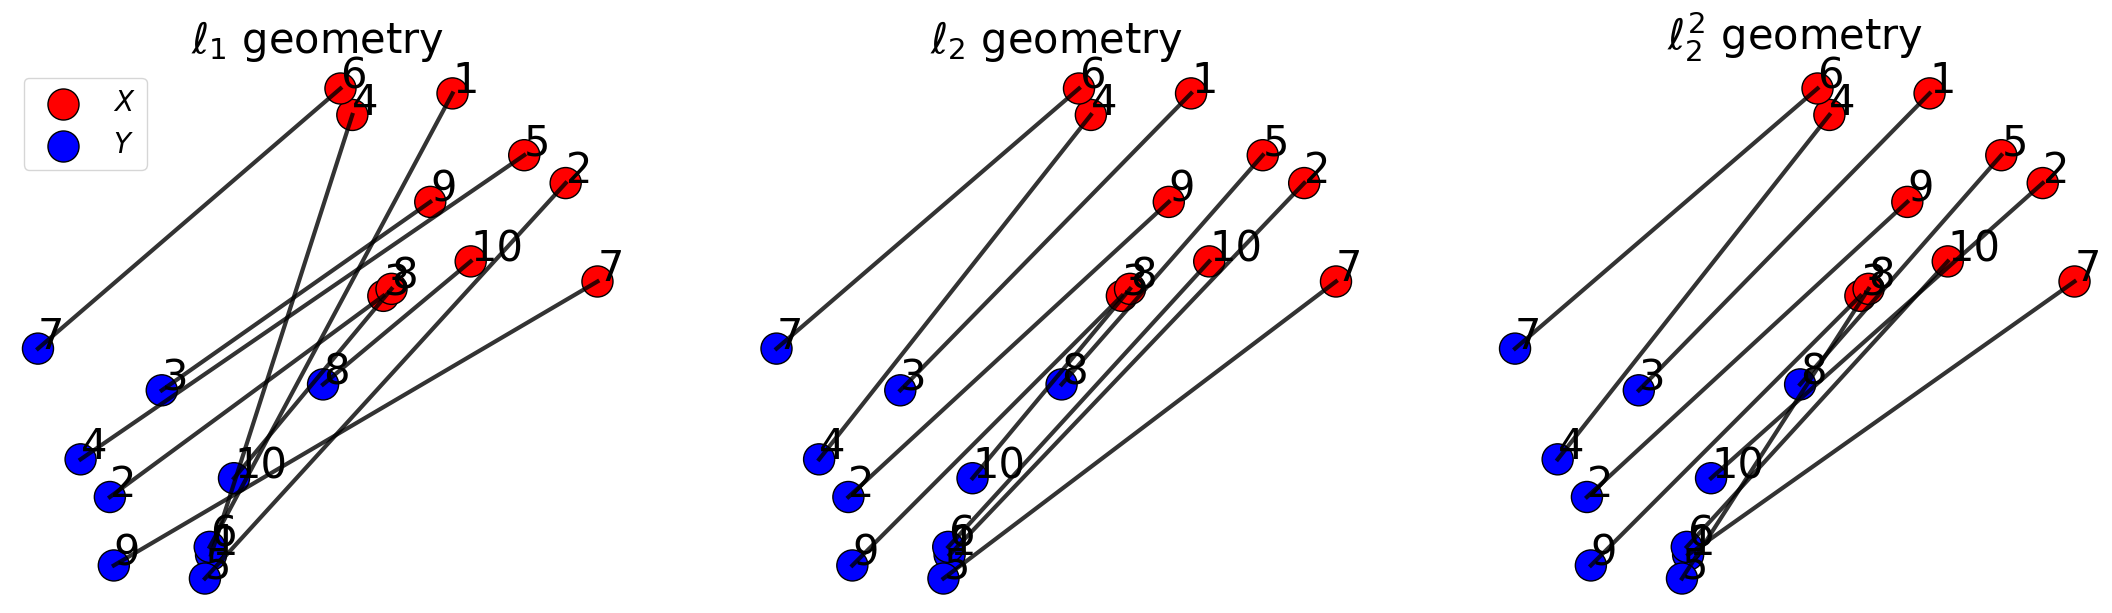

In [26]:
fig, ax = plt.subplots(
    1, 3, figsize=(9*3, 7)
)
plot_assignement(
    ax=ax[0],
    X=X, a=a, X_label=r"$X$",
    Y=Y, b=b, Y_label=r"$Y$",
    optimal_plan=optimal_plan_l1,
    title=r"$\ell_1$ geometry"
)
plot_assignement(
    ax=ax[1],
    X=X, a=a,
    Y=Y, b=b,
    optimal_plan=optimal_plan_l2,
    title=r"$\ell_2$ geometry"
)
plot_assignement(
    ax=ax[2],
    X=X, a=a,
    Y=Y, b=b,
    optimal_plan=optimal_plan_l2_sq,
    title=r"$\ell_2^2$ geometry"
)
plt.show()

### In dimension $d = 1$

Let assume in this subsection that the cost is of the form $c(x, y) = \|x - y\|_p^q$ with $p, q \geq 1$, which covers the costs we considered in the previous examples, and that the points are in $\mathbb{R}$, i.e. $X_1, ..., X_n, Y_1, ... , Y_n \in \mathbb{R}$. Then, computing OT boils down to sorting the points. Indeed, for all costs of the above form, the optimal permutation between $X$ and $Y$ is $\sigma^* = \sigma_X^{-1} \circ \sigma_Y$ where $\sigma_X$ is the permutation sorting the $X_i$ and $\sigma_Y$ the one sorting the $Y_i$. In particular, one has:

$$
W_c(\mu, \nu) = \frac{1}{n} \sum_{i=1}^n c(X_i, Y_{\sigma_X^{-1} \circ \sigma_Y(i)}) = \frac{1}{n} \sum_{i=1}^n c(X_{\sigma_X(i)}, Y_{\sigma_Y(i)})
$$

Thus, to compute the optimal transport cost, it is sufficient to sort $X$ and $Y$.

Let's check this fact on an example, by comparing the transport cost obtained by sorting the points to the one obtained with the function `ot.emd`. To simplify, we generate points $X,Y \subset \mathbb{R}$ s.t. $X$ is sorted, i.e. $\sigma_X = I_d$ and then $\sigma^*=\sigma_Y$. Therefore, computing the optimal assignement amounts to sort $Y$.



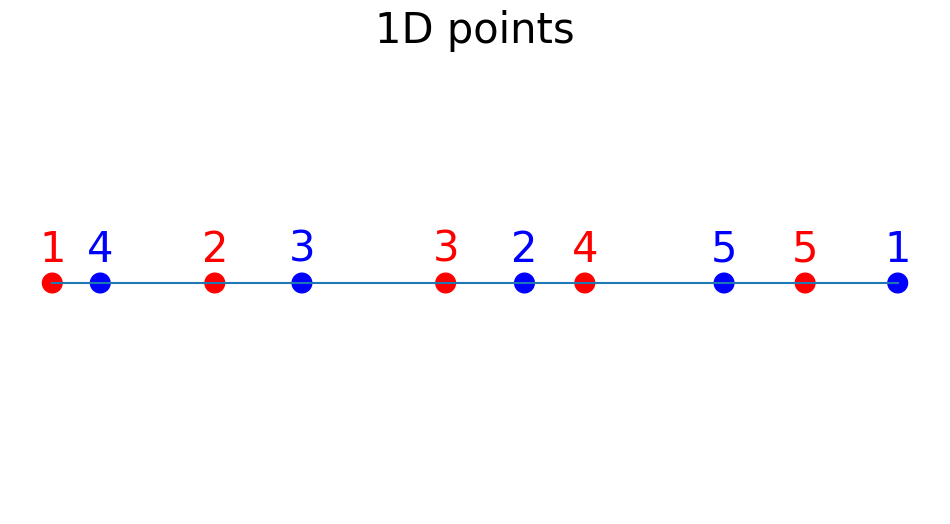

In [27]:
# generate points
n = 5
X = np.arange(0, 2*n, 2) + .25 * np.random.normal(size=(n,))
a = np.ones(n) / n
Y = np.arange(1, 2*n+1, 2) + .25 * np.random.normal(size=(n,))
np.random.shuffle(Y)
b = np.ones(n) / n

# plot points
fig, ax = plt.subplots(figsize=(12, 6))
plot_points_1D(
    ax,
    X, Y,
    title="1D points"
)

***

**Question:**
* For $\ell_1$ and $\ell_2^2$ geometries ($\ell_2$ and $\ell_1$ coincides on $\mathbb{R}$), compute the optimal assignement and optimal transport cost by sorting $Y$. Put the assignement into a vector $s \in \mathbb{R}^n$, s.t. $X_i$ is mapped to $Y_{s_i}$, i.e. $s_i = \sigma^*(i)$. Is it different according to the geometry?
* Put now the assignment you obtained by sorting the points in the form of a transport plan $P^* \in \mathbb{R}^{n \times n}$. Check that you obtain the results with `ot.emd`.

**Answer:**

In [28]:
# sort the points
Y_sorted = sorted(Y) # TODO

# get optimal assignement as a vector
assignement = np.argsort(Y) # TODO

# transform it to a transport plan
optimal_plan = np.eye(n)[assignement]/n # TODO

print(
    f"optimal transport plan obtained by sorting the points:\n {optimal_plan}"
)

optimal transport plan obtained by sorting the points:
 [[0.  0.  0.  0.2 0. ]
 [0.  0.  0.2 0.  0. ]
 [0.  0.2 0.  0.  0. ]
 [0.  0.  0.  0.  0.2]
 [0.2 0.  0.  0.  0. ]]


In [29]:
# l1 geometry
print("l1 geometry:")
C_l1 = get_cost_matrix(X,Y,l1)
optimal_plan_l1, optimal_cost_l1 = compute_transport(
    C_l1,a,b,False
)

print(
    f"is it equal to the one obtained by sorting the points? "
    f"{np.array_equal(optimal_plan_l1, optimal_plan)}"
)

l1 geometry:
is it equal to the one obtained by sorting the points? True


In [30]:
# squared l2 geometry
C_l2_sq = get_cost_matrix(
    X,Y,l2_sq
)
optimal_plan_l2_sq, optimal_cost_l2_sq = compute_transport(
    C_l2_sq,a,b,
)

print(
    f"is permutation matrix? {is_permutation(optimal_plan_l2_sq)}"
)
print(
    f"is it equal to the one obtained by sorting the points? "
    f"{np.array_equal(optimal_plan_l2_sq, optimal_plan)}"
)

is permutation matrix? True
is it equal to the one obtained by sorting the points? True


***

Finally, one can plot the assignement.

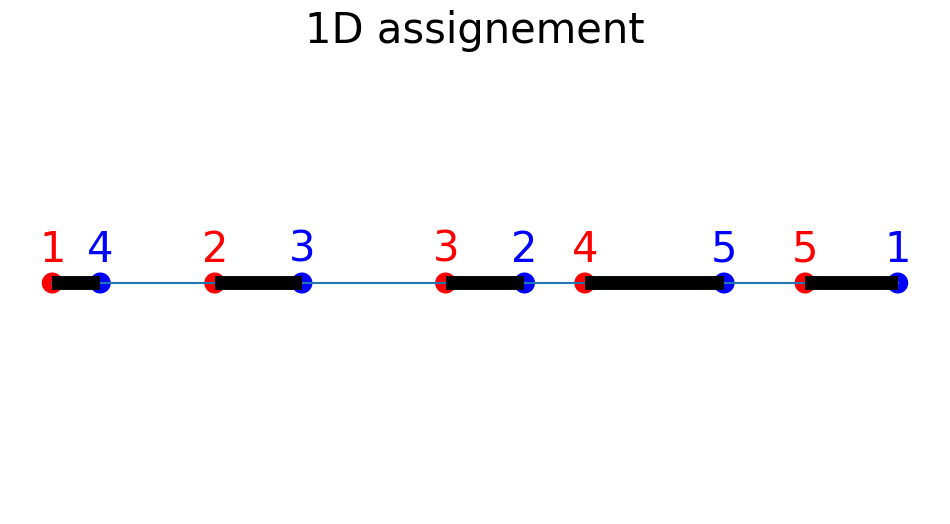

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_assignement_1D(
    ax,
    X, Y,
    title="1D assignement"
)
plt.show()

# II. Entropy Regularized Optimal Transport

## II.1 Reminders on Sinkhorn Algorithm

### Adding negative entropy as a regularizer

In real applications, and especially in Machine Learning, we often have to deal with huge numbers of points. In this case, the linear programming algorithms which have cubic complexity will take too much time to run.

That's why in practise, among other reasons, people minimize another criterion given by
$$
    \min_{P \in \mathcal{U}(a,b)} \langle C, P \rangle + \epsilon \sum_{ij} P_{ij} [ \log(P_{ij}) - 1].
$$
When $\epsilon$ is sufficiently small, we can consider that a solution to the above problem (often refered to as "Entropy-regularized Optimal Transport") is a good approximation of a real optimal transport plan.

### The Sinkhorn iterates

In order to solve this problem, one can remark that the optimality conditions imply that a solution $P_\epsilon^*$ necessarily is of the form $P_\epsilon^* = \text{diag}(u) \, K \, \text{diag}(v)$, where $K = \exp(-C/\epsilon)$ and $u,v$ are two non-negative vectors.

$P_\epsilon^*$ should verify the constraints, i.e. $P_\epsilon^* \in U(a,b)$, so that
$$
    P_\epsilon^* 1_m = a \text{  and  } (P_\epsilon^*)^T 1_n = b
$$
which can be rewritten as
$$
    u \odot (Kv) = a \text{  and  } v \odot (K^T u) = b
$$

Then Sinkhorn's algorithm alternate between the resolution of these two equations, and reads at iteration $t$:
$$
    u^{t+1} \leftarrow \frac{a}{Kv^t} \text{  and  } v^{t+1} \leftarrow \frac{b}{K^T u^{t+1}}
$$

### Initialization and convergence

Usually, it starts from $v^{0} = \mathrm{1}_m$ and alternate the above updates until $\|u^{t+1} \odot (Kv^{t+1}) - a\|_1 + \|v^{t+1} \odot (K^T u^{t+1}) - b\|_1 \leq \tau$, where $\tau > 0$ is a fixed convergence threshold. Actually, since at the end of each iteration, one exactly has $v^{t+1} \odot (K^T u^{t+1}) = b$, it just remains to test if $\|u^{t+1} \odot (Kv^{t+1}) - a\|_1 \leq \tau$.

From an entropic optimal transport plan $P^*_\epsilon$, we can approximate the optimal transport cost by $\sum_{i,j=1}^n P^*_{\epsilon_{ij}} C_{ij} = ⟨C, P^*_\epsilon⟩$. For the rest of the section, we call this quantity the entropic optimal transport cost.

## II.2 Using your own Sinkhorn


### Sinkhorn Implementation

In this section, you will implement your own version of the Sinkhorn Algorithm.

***

**Question:** Complete the following Sinkhorn algorithm, by:
* Computing the kernel matrix $K = \exp(-C / \epsilon)$,
* Starting from $v^{0} = \mathrm{1}_m$,
* Alternating the updates $u^{t+1} \odot (Kv^t) = a$ and $v^{t+1} \odot (K^T u^{t+1}) = b$,
* Declaring convergence when $\|u^t \odot (Kv^t) - a\|_1 + \|v^t \odot (K^T u^t) - b\|_1 \leq \tau$.

**Remark:** to avoid infinite loops, you should also use also a maximum number of iterations ``max_iter``, to stop the algorithm after a fixed number of iterations if the convergence is not reached.

**Answer:**

In [32]:
# Correction

def sinkhorn(
    a: np.ndarray,
    b: np.ndarray,
    C: np.ndarray,
    epsilon: float,
    max_iters: int = 100,
    tau: float = 1e-4
) -> np.ndarray:
    """
        Sinkhorn's algorithm. It should output the optimal transport plan.
    """
    
    v = np.ones((len(b),))
    K = np.exp(-C/epsilon)
    
    for i in range(max_iters):
        u = a / (K@v)
        v = b / (K.T@u)
        
        if np.sum(np.abs(u*(K@v) - a)) < tau:
            break
    
    return np.diag(u) @ K @ np.diag(v)

In [27]:
def sinkhorn(
    a: np.ndarray,
    b: np.ndarray,
    C: np.ndarray,
    epsilon: float,
    max_iters: int = 100,
    tau: float = 1e-4
) -> np.ndarray:
    """
        Sinkhorn's algorithm. It should output the optimal transport plan.
    """
    # prime
    n,m = len(a),len(b)
    update = float('inf')
    num_iter = 0
    K = np.exp(-C/epsilon)
    assert K.shape == (n,m)
    u,v = np.ones(n),np.ones(m)

    # iteratively
    while update > epsilon:
        num_iter += 1
        new_u,new_v = a/(K@v),b/(K.T@u)
        update = np.sum(abs(new_u-u))+np.sum(abs(new_v-v))
        u,v = new_u,new_v
        if num_iter > max_iters:
            break
    
    # return
    plan = u[:,None] * K * v[None,:]
    assert plan.shape == (n,m)
    return plan


***

Now, we can test the Sinkhorn algorithm on the "croissant" transport example.

***
**Question:**
* Complete the following fuction that takes as input the cost matrix $C$ and the weights vectors $a$ and $b$ and outputs the entropic optimal transport plan and the entropic optimal transport cost using the `sinkhorn` function. As for the exact transport, it has an option to display the results.
* Use that function on the croissant transport to compute and display the optimal plan and the optimal cost for the $\ell_1, \ell_2$ and $\ell_2^2$ geometries.
* Each time you run the Sinkhorn algorithm, you should use $\epsilon = 0.1 \cdot \bar{C}$, with $\bar{C} = \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m C_{ij}$ is the mean of the cost matrix.  It remains to adapt the $\epsilon$ value according to the cost matrix, to control the magnitude of the entries of $C / \epsilon$. Why this strategy? What will happen if $\epsilon$ is too small compared to the entries of $C$?

**Answer:**

In [33]:
def compute_transport_sinkhorn(
    C: np.ndarray,
    a: np.ndarray,
    b: np.ndarray,
    epsilon: float,
    max_iters: int = 10_000,
    tau: float = 1e-4,
    verbose: bool = False,
):
  """
  Compute the entropic optimal transport plan and the entropic optimal transport cost
  for cost matrix ``C`` and weight vectors $a$ and $b$.
  If ``verbose`` is set to True, it displays the results.
  """
  optimal_plan_sinkhorn = sinkhorn(a,b,C,epsilon,max_iters,tau) # TODO
  optimal_cost_sinkhorn = np.sum(optimal_plan_sinkhorn * C) # TODO
    
  if verbose:
    print(
        f"entropic optimal transport plan: \n{optimal_plan_sinkhorn}"
    )
    print(
        f"entropic transport cost: {optimal_cost_sinkhorn}"
    )
      
  return optimal_plan_sinkhorn, optimal_cost_sinkhorn

In [34]:
X,Y = bakery_pos,cafe_pos
a,b = bakery_prod,cafe_prod

In [35]:
# l1 geometry
print("l1 geometry:")

C_l1 = get_cost_matrix(X,Y,l1) # TODO
epsilon = 0.1*np.mean(C_l1) # TODO

optimal_plan_sinkhorn_l1_croissant, optimal_cost_sinkhorn_l1_croissant = compute_transport_sinkhorn(C_l1,a,b,epsilon,verbose=True)

l1 geometry:
entropic optimal transport plan: 
[[2.16634160e-02 2.66548426e-02 2.18982214e-02 8.01569494e-05
  6.82465147e-09]
 [7.57782608e-06 1.52528354e-04 1.08265880e-01 3.99464934e-04
  3.40108870e-08]
 [8.30982731e-02 1.02244788e-01 3.11599954e-04 3.07472472e-04
  2.61785469e-08]
 [3.04524945e-02 3.74689960e-02 7.90964135e-07 1.12677477e-04
  9.59348521e-09]
 [9.53306643e-04 1.91883914e-02 2.13448920e-03 6.83516475e-02
  8.07899365e-05]
 [5.77703469e-05 1.16281580e-03 7.58256442e-02 4.14210728e-03
  2.76401980e-02]
 [3.57517966e-04 4.68700852e-03 6.66228919e-05 2.56338736e-02
  1.71054319e-01]
 [4.93506867e-02 7.98711414e-03 1.13531827e-04 1.00519085e-01
  7.57382233e-03]]
entropic transport cost: 182.78456782857697


In [36]:
# l2 geometry
print("l2 geometry:")

C_l2 = get_cost_matrix(X,Y,l2) 
epsilon = np.mean(C_l2)*0.1

optimal_plan_sinkhorn_l2_croissant, optimal_cost_sinkhorn_l2_croissant = compute_transport_sinkhorn(C_l2,a,b,epsilon,verbose=True)

l2 geometry:
entropic optimal transport plan: 
[[2.81594309e-02 3.81299710e-02 3.91824693e-03 9.42428077e-05
  2.18408649e-09]
 [1.01304400e-05 1.02594298e-04 1.08703004e-01 1.67284100e-05
  1.11047122e-08]
 [7.86838735e-02 1.06155289e-01 9.27269783e-04 1.95447361e-04
  3.25687545e-09]
 [4.57622098e-02 2.22331194e-02 9.05781228e-06 3.05636023e-05
  4.09756601e-10]
 [3.00267768e-03 1.40433223e-02 8.63308969e-03 6.49943405e-02
  3.32506469e-05]
 [2.79695021e-04 1.34072145e-03 8.22654232e-02 7.76186061e-03
  1.71853968e-02]
 [4.39728832e-04 9.54020637e-04 3.78960365e-03 1.05182110e-02
  1.86085005e-01]
 [2.96032968e-02 1.65874468e-02 3.71084899e-04 1.15935091e-01
  3.04553714e-03]]
entropic transport cost: 144.02418156877582


In [37]:
# squared l2 geometry
print("squared l2 geometry:")
C_l2_sq = get_cost_matrix(X,Y,l2_sq)
epsilon = 0.1*np.mean(C_l2_sq)

optimal_plan_sinkhorn_l2_sq_croissant, optimal_cost_sinkhorn_l2_sq_croissant = compute_transport_sinkhorn(C_l2_sq,a,b,epsilon,verbose=True)

squared l2 geometry:
entropic optimal transport plan: 
[[1.78815356e-02 5.10504947e-02 1.36701079e-03 3.35095475e-06
  4.95068162e-17]
 [3.18369567e-06 4.22505521e-04 1.08337542e-01 6.78108180e-05
  2.73434582e-10]
 [9.30218411e-02 9.26151404e-02 2.65193774e-04 6.01453907e-05
  2.68266366e-14]
 [5.27235339e-02 1.52732996e-02 2.91233381e-06 3.54334563e-05
  9.68421779e-14]
 [4.11450701e-03 2.93000501e-02 1.16876518e-02 4.56006838e-02
  4.27083312e-06]
 [2.13771127e-09 2.08887090e-06 8.65624201e-02 2.98780206e-03
  1.92786968e-02]
 [9.03829717e-08 5.20857787e-06 3.75712162e-04 1.45766924e-02
  1.86831463e-01]
 [1.81963493e-02 1.08776974e-02 1.83371953e-05 1.36214566e-01
  2.34775871e-04]]
entropic transport cost: 25888.307726926756




***

### The effect of $\epsilon$

Now we can display the transportation plans obtained with Sinkhorn's algortihm, as we did for the exact OT.

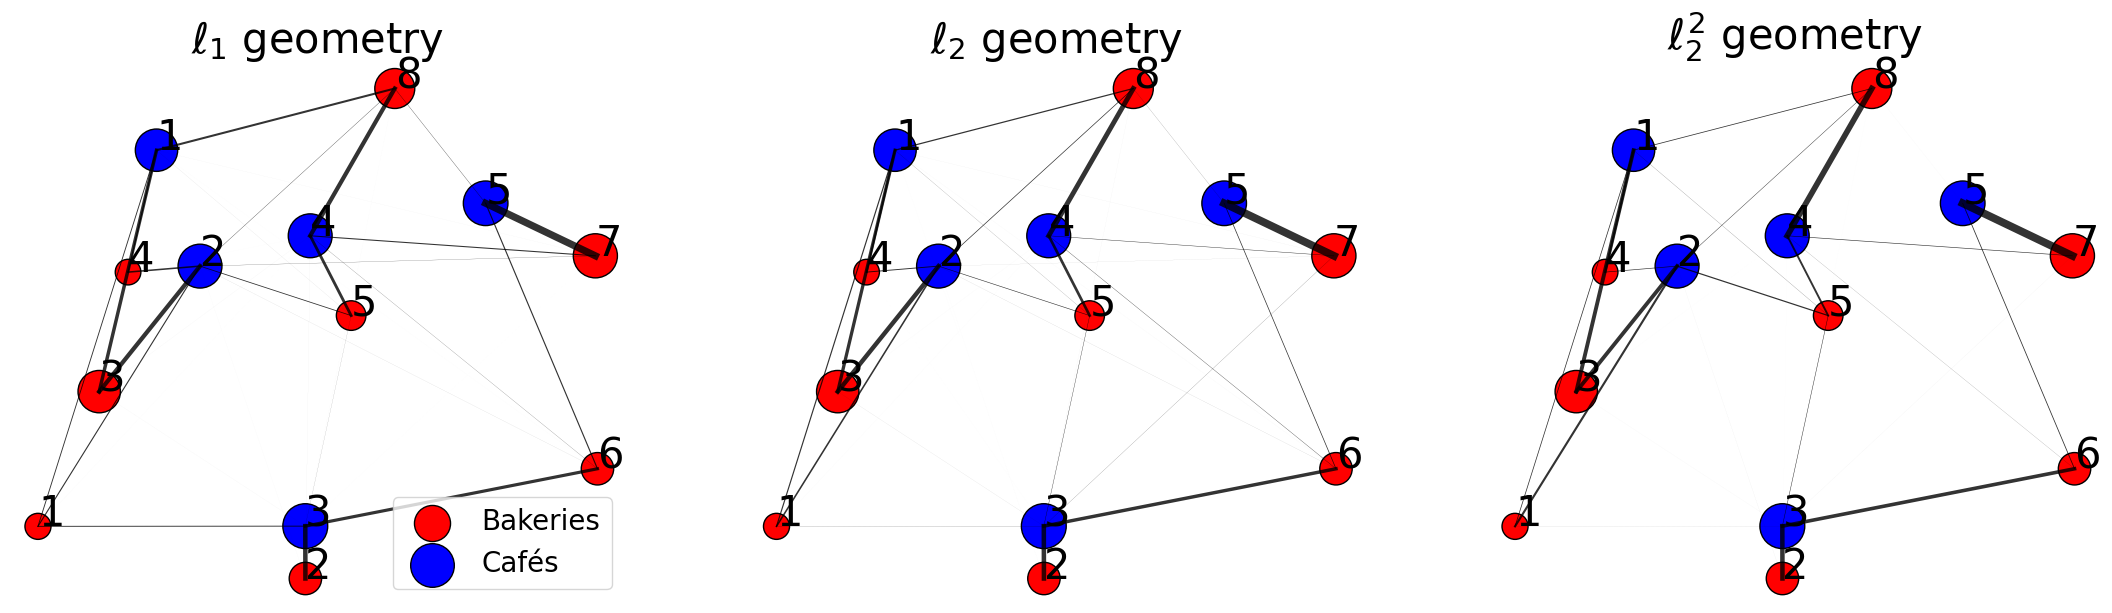

In [38]:
fig, ax = plt.subplots(
    1, 3, figsize=(9*3, 7)
)
plot_assignement(
    ax=ax[0],
    X=bakery_pos, a=bakery_prod, X_label="Bakeries",
    Y=cafe_pos, b=cafe_prod, Y_label="Cafés",
    optimal_plan=optimal_plan_sinkhorn_l1_croissant,
    title=r"$\ell_1$ geometry"
)

plot_assignement(
    ax=ax[1],
    X=bakery_pos, a=bakery_prod,
    Y=cafe_pos, b=cafe_prod,
    optimal_plan=optimal_plan_sinkhorn_l2_croissant,
    title=r"$\ell_2$ geometry"
)

plot_assignement(
    ax=ax[2],
    X=bakery_pos, a=bakery_prod,
    Y=cafe_pos, b=cafe_prod,
    optimal_plan=optimal_plan_sinkhorn_l2_sq_croissant,
    title=r"$\ell_2^2$ geometry"
)

plt.show()

The above transport plans are obtained for $\epsilon = 0.1 \cdot \bar{C}$. Let's increase epsilon to $\epsilon = 10 \cdot \bar{C}$ and replot the optimal  transport plans to visualize the effect of epsilon.

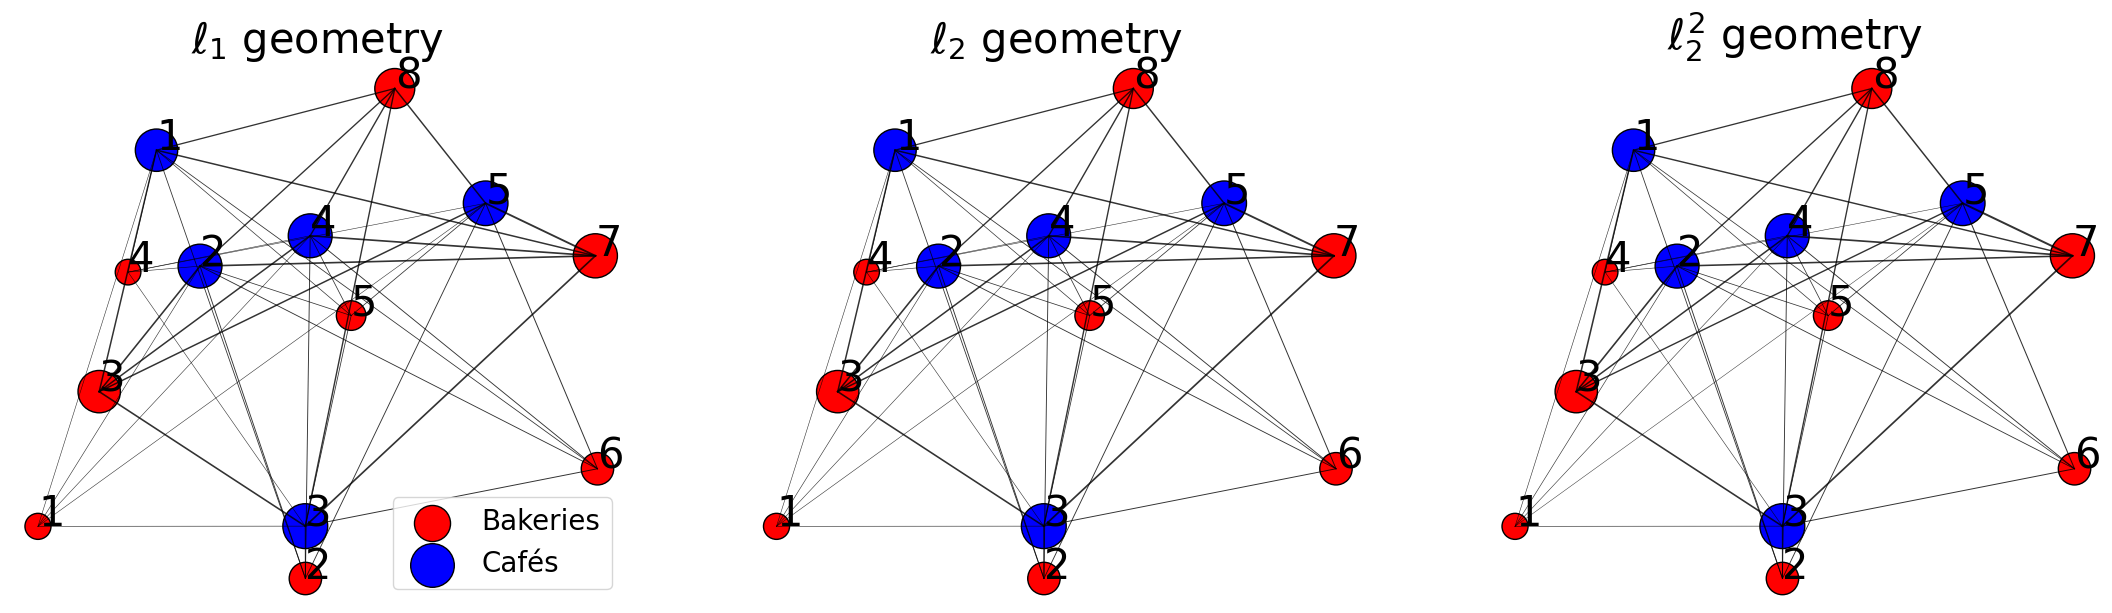

In [39]:
# l1 geometry
epsilon = 10 * np.mean(C_l1)

optimal_plan_sinkhorn_l1_croissant, optimal_cost_sinkhorn_l1_croissant = compute_transport_sinkhorn(
    C=C_l1,
    a=bakery_prod,
    b=cafe_prod,
    epsilon=epsilon,
    verbose=False,
)

# l2 geometry
epsilon = 10 * np.mean(C_l2)

optimal_plan_sinkhorn_l2_croissant, optimal_cost_sinkhorn_l2_croissant = compute_transport_sinkhorn(
    C=C_l2,
    a=bakery_prod,
    b=cafe_prod,
    epsilon=epsilon,
    verbose=False
)

# squared l2 geometry
epsilon = 10 * np.mean(C_l2_sq)

optimal_plan_sinkhorn_l2_sq_croissant, optimal_cost_sinkhorn_l2_sq_croissant = compute_transport_sinkhorn(
    C=C_l2_sq,
    a=bakery_prod,
    b=cafe_prod,
    epsilon=epsilon,
    verbose=False
)

fig, ax = plt.subplots(
    1, 3, figsize=(9*3, 7)
)
plot_assignement(
    ax=ax[0],
    X=bakery_pos, a=bakery_prod, X_label="Bakeries",
    Y=cafe_pos, b=cafe_prod, Y_label="Cafés",
    optimal_plan=optimal_plan_sinkhorn_l1_croissant,
    title=r"$\ell_1$ geometry"
)
plot_assignement(
    ax=ax[1],
    X=bakery_pos, a=bakery_prod,
    Y=cafe_pos, b=cafe_prod,
    optimal_plan=optimal_plan_sinkhorn_l2_croissant,
    title=r"$\ell_2$ geometry"
)
plot_assignement(
    ax=ax[2],
    X=bakery_pos, a=bakery_prod,
    Y=cafe_pos, b=cafe_prod,
    optimal_plan=optimal_plan_sinkhorn_l2_sq_croissant,
    title=r"$\ell_2^2$ geometry"
)
plt.show()

***

**Question:** What do you observe in relation to the transport plans obtained for the exact optimal transport?

**Answer:** Va vers le plan de coupling indépendant.

***

### Sinkhorn consistency

We now show that this Sinkhorn algorithm is consistent with classical optimal transport, using the "croissant" transport example and focusing on the $\ell_2$ cost.

***

**Question:** Complete the following code to compute, for various $\epsilon'$, values on a regular grid:
* Set $\epsilon = \epsilon' \cdot \bar{C}$,
* The deviation of the entropic optimal plan $P^*_\epsilon$ to the exact optimal plan $P^*$, namely $\|P^*_\epsilon - P^*\|_2$.
* The deviation of the entropic optimal cost $\langle C, P^*_\epsilon \rangle$ to the exact optimal plan $\langle C, P^*_\epsilon \rangle$, namely: $100 \cdot \frac{\langle C, P^*_\epsilon \rangle - \langle C, P^* \rangle}{\langle C, P^*\rangle}$.

We remind that the excat optimal transport plan for the $\ell_2$ cost is stored as variable `optimal_plan_l2_croissant`.

**Answer:**

In [40]:
plan_diff = []
distance_diff = []
grid = np.linspace(0.01, 5, 100)
C_mean = np.mean(C_l2)

for epsilon_prime in grid:
  epsilon = epsilon_prime*C_mean
  optimal_plan_sinkhorn_l2_croissant, optimal_cost_sinkhorn_l2_croissant = compute_transport_sinkhorn(C_l2,a,b,epsilon)
    
  assert optimal_cost_sinkhorn_l2_croissant != np.nan, (
      "Optimal cost is nan due to numerical instabilities."
  )
  plan_diff.append(
      np.linalg.norm(optimal_plan_sinkhorn_l2_croissant-optimal_plan_l2_croissant)
  )
  distance_diff.append(
      100*(optimal_cost_sinkhorn_l2_croissant-optimal_cost_l2_croissant)/optimal_cost_l2_croissant
  )

***

Now, let's plot the results.

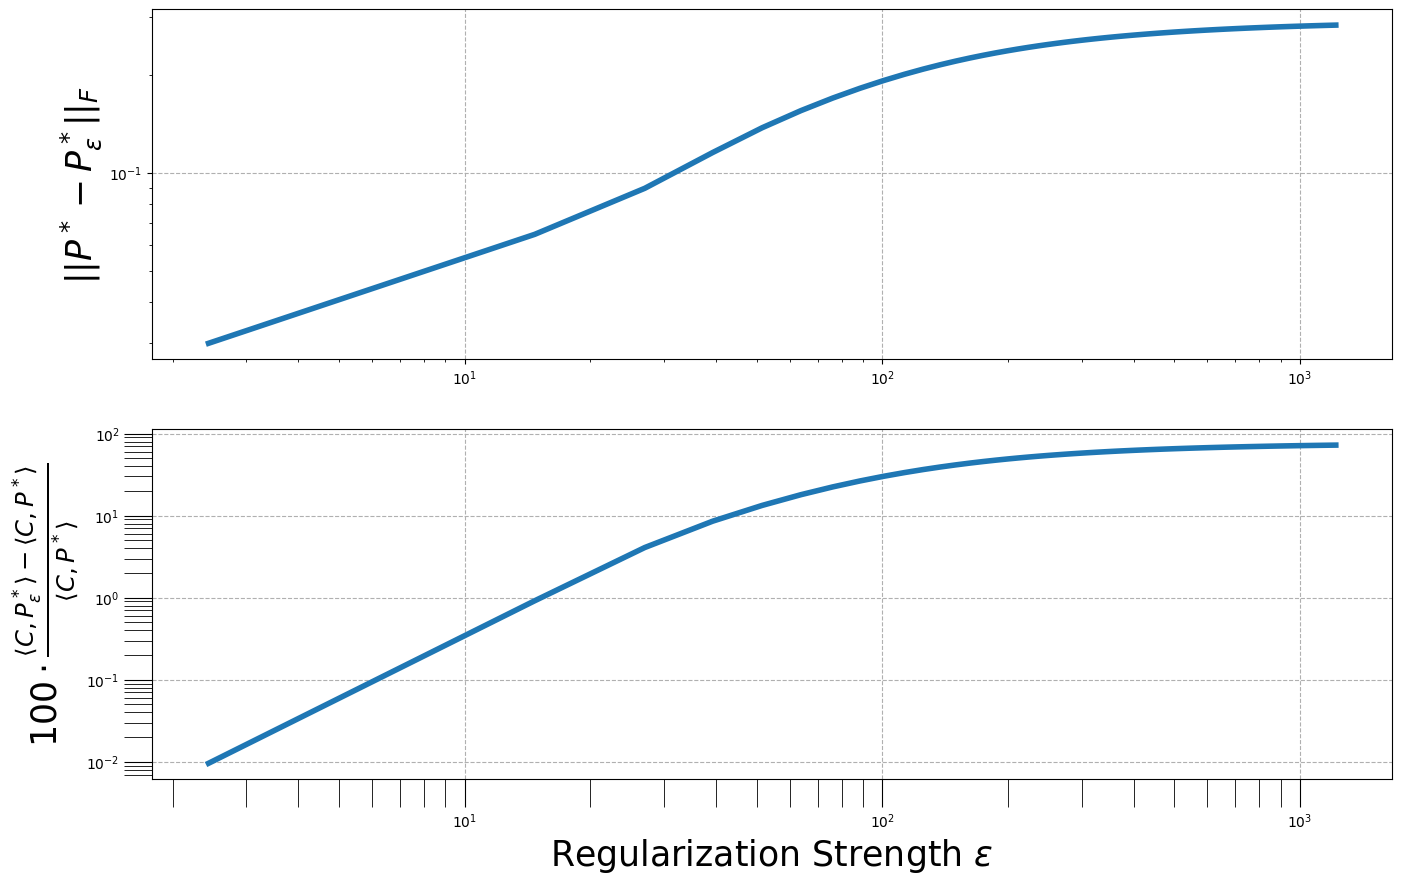

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5*2))
reg_strengths = np.mean(C_l2) * grid
plot_consistency(
    ax,
    reg_strengths,
    plan_diff,
    distance_diff
)

plt.show()

## II.3 Using `OTT`


### Install `OTT`

First, you need to install `OTT`.

In [38]:
! pip install ott-jax

ERROR: Could not find a version that satisfies the requirement ott-jax (from versions: none)
ERROR: No matching distribution found for ott-jax


Then we load the required pakages.

In [43]:
import jax
import jax.numpy as jnp
import jax.random as random

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

### A world about `OTT` and `JAX`




`OTT` is a python library that allows to compute and differentiate the entropic optimal transport. In this lab session, we will focus on entropic optimal transport computation, and not differentiation. differentiation will be takcled later.

`OTT` is based on `JAX`, a package similar to `PyTorch` or `TensorFlow`, which allows to do automatic differentiation and GPU programming. It also provides useful primitives for efficient computation, such as the just-in-time (`jit`) compilation or the automatic vectorization map `vmap`. For more informations on `JAX`, see the tutorial https://jax.readthedocs.io/en/latest/notebooks/quickstart.html.

Unlike `PyTorch` or `TensorFlow`, `JAX` is very close to `numpy` thanks to the `jax.numpy` package, which implements most of the `numpy` features, but for the `JAX` data structures. For this lab session, you only need to know how to manipulate `jax.numpy` Arrays and generate random numbers with `jax.random`.

First, let's have a look to `jax.numpy` and see that it works (almost) exactly as numpy. Usually, one imports `jax.numpy as jnp` as done in the above cells, and developp as with `numpy`, by just replacing `np` by `jnp`. Note that `jax.numpy` Arrays are called `DeviceArray`. For more informations on `jax.numpy`, see https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html.

In [45]:
d = 5
u = 5 * jnp.ones(5)
Id = jnp.eye(5)
print(type(u))
print(f"u = {u}")
print(f"Id = {Id}")
print(f"Id @ u = {jnp.dot(Id, u)}")
print(f"sum(u) = {jnp.sum(u)}")
print(f"var(u) = {jnp.var(u)}")

<class 'jaxlib.xla_extension.ArrayImpl'>
u = [5. 5. 5. 5. 5.]
Id = [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Id @ u = [5. 5. 5. 5. 5.]
sum(u) = 25.0
var(u) = 0.0


With `numpy.random`, you can generate random numbers on the fly without giving the `seed`. For example, `np.random.rand()` generates a random number $X \sim U([0, 1])$. Indeed, `numpy.random` uses an internal seed which is updated each time a random number generating function is called. On the other hand, with `jax.random`, we must give the `seed` each time we generate random numbers. To some extent, we want to always control the randomness. Moreover, we do not pass exactly a `seed` but a `jax.random.PRNGKey` key which is itself instantiated from a `seed`. Let's see it on an example.

In [46]:
rng = jax.random.PRNGKey(0)
n, d = 13, 2
x = jax.random.normal(rng, (n, d))
print(f"x = {x}")

x = [[ 2.516351   -1.3947194 ]
 [-0.8633262   0.6413567 ]
 [-0.37789643 -0.6044598 ]
 [ 1.9069     -0.17918469]
 [-0.7583423  -0.5160155 ]
 [ 1.2666148  -0.12342127]
 [ 0.28430256 -0.17251171]
 [ 1.0661486   1.5814103 ]
 [-2.0284636  -0.13168257]
 [-0.14515765  0.21532312]
 [-0.69525063 -0.9314128 ]
 [-0.89809936 -0.25272107]
 [-0.34937173  1.8394127 ]]


Then, to have new keys to generate new random numbers, we need to split the key via `jax.random.split`, which generate $n \geq 2$ new keys from a key.

In [47]:
rng1, rng2, rng3 = jax.random.split(rng, 3)
a = jax.random.normal(rng1, (n, d))
b = jax.random.normal(rng2, (n, d))
c = jax.random.normal(rng2, (n, d))
print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")

a = [[-0.38696066 -0.96707183]
 [ 1.0078175  -0.6096286 ]
 [-1.153353    1.0749092 ]
 [-1.2452031  -0.63885343]
 [ 0.01121208  0.2842425 ]
 [ 0.5296049   0.26609063]
 [ 0.8728492   1.0844501 ]
 [ 1.4472795  -0.82503337]
 [-0.41826957  0.21321987]
 [ 1.9602116   0.17687395]
 [-0.9978761  -2.0551765 ]
 [-0.4094941  -1.4577458 ]
 [-1.0969195  -0.66684234]]
b = [[ 0.10911155 -0.45371595]
 [ 0.12062439 -0.06927001]
 [ 0.00600028  2.3732579 ]
 [-0.17656058  1.7653493 ]
 [-0.06429235  0.487175  ]
 [-1.1079016  -1.0277865 ]
 [-0.0553451  -0.28271845]
 [-0.9633478  -0.05370665]
 [ 0.20281292 -0.16658288]
 [ 0.8015828  -0.61697495]
 [-0.30176872 -1.1862007 ]
 [-3.106658   -0.03262986]
 [ 0.53711027  0.21359496]]
c = [[ 0.10911155 -0.45371595]
 [ 0.12062439 -0.06927001]
 [ 0.00600028  2.3732579 ]
 [-0.17656058  1.7653493 ]
 [-0.06429235  0.487175  ]
 [-1.1079016  -1.0277865 ]
 [-0.0553451  -0.28271845]
 [-0.9633478  -0.05370665]
 [ 0.20281292 -0.16658288]
 [ 0.8015828  -0.61697495]
 [-0.30176872 

You now know everything you need for the moment!

### Entropic optimal transport with `OTT`


Now let's use the implementation of the `OTT` Sinkhorn algorithm, on some random weighted point clouds. Then you will, by yourself, use it on the "croissant" transport example.

Let's first generate the data.



In [50]:
# generate data
rng = jax.random.PRNGKey(0)
rng1, rng2 = jax.random.split(rng, 2)
n, m, d = 13, 17, 2
x = jax.random.normal(rng1, (n, d))
y = jax.random.normal(rng2, (m, d)) + 1
a = jnp.ones(n) / n
b = jnp.ones(m) / m

Then, we have to define a `PointCloud` `geometry` which contains:
* the point clouds `X` and `Y`,
* the cost function `cost_fn`,
* the entropic regularization strength `epsilon`.

Note that the `geometry` does not contain the weight vectors `a` and `b`, these are passed later.

The `cost_fn` should be an istance of `ott.geometry.CostFn`. Most of the usual costs are implemented. For example, the three costs $\ell_1, \ell_2$ and $\ell_2^2$ are implemented. Here, we will focus on the $\ell_2$ cost, implemented by `ott.geometry.costs.Euclidean`. See https://ott-jax.readthedocs.io/en/latest/_autosummary/ott.geometry.costs.CostFn.html#ott.geometry.costs.CostFn for more information on the provided `cost_fn`.

We still choose `epsilon` to be $0.1 \cdot \bar{C}$. To do this, we set `relative_epsilon=True` when instantiating the geometry. The term `relative` means that `epsilon` is chosen relatively to the mean of the cost matrix. Passing then `epsilon=0.1`, the value of `epsilon` used by Sinkhorn will be $0.1 \cdot \bar{C}$.

In [51]:
# define geometry
geom = pointcloud.PointCloud(
    x=x, y=y,
    cost_fn=costs.Euclidean(),
    epsilon=.1,
    scale_cost='mean'
)

We then define an optimization problem from this geometry, which is the problem we will solve with the Sinkhorn algorithm.  We instantiate this optimization problem as an object of the class `linear_problem.LinearProblem`. We pass the weight vectors `a` and `b` because they define the constraints of the linear problem. Then, we instantiate a Sinkhorn solver, object of the class `sinkhorn.Sinkhorn`, which we will use to solve this optimization problem.

The `OTT` library is designed in this way because it allows to solve other optimal transport problems, which do not necessarily have a linear problem structure, and which use other solvers than Sinkhorn.

In [52]:
# create optimization problem
ot_prob = linear_problem.LinearProblem(geom, a=a, b=b)

# create sinkhorn solver
solver = sinkhorn.Sinkhorn(ot_prob)

# solve the OT problem
ot_sol = solver(ot_prob)

The `ot` output object contains several callables and properties, notably a boolean assessing the Sinkhorn convergence, the marginal errors throughtout iterations and the optimal transport plan.

In [53]:
print(
    " Sinkhorn has converged: ",
    ot_sol.converged,
    "\n",
    "Error upon last iteration: ",
    ot_sol.errors[(ot_sol.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot_sol.errors > -1),
    " iterations to converge. \n",
    "entropic OT matrix: ",
    ot_sol.matrix,
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.00016910955 
 Sinkhorn required  2  iterations to converge. 
 entropic OT matrix:  [[1.47490285e-03 1.14393129e-03 5.41622285e-03 1.77058834e-03
  3.92138362e-02 4.13846778e-04 7.84370932e-04 1.09052821e-03
  1.15650869e-03 1.58313604e-03 4.93969349e-03 1.65287335e-03
  8.02386925e-03 5.93708595e-03 1.06891140e-03 7.82342628e-04
  4.70465253e-04]
 [1.74196046e-02 1.96549459e-03 2.77426443e-04 4.25373000e-04
  7.74052169e-05 1.38107943e-03 4.79919314e-02 1.19070057e-03
  1.12308376e-03 5.18609828e-04 6.27714826e-06 4.95883520e-04
  6.71735441e-04 1.07142914e-04 1.35998160e-03 9.77332471e-04
  9.34020907e-04]
 [3.33374948e-04 1.44224418e-02 1.31947186e-03 4.18251753e-03
  3.04022080e-07 4.65975888e-03 6.52307863e-05 1.09514948e-02
  8.90913326e-03 4.97117499e-03 1.14037866e-05 4.85193031e-03
  5.68547635e-04 6.03165943e-04 9.86037403e-03 6.43675309e-03
  4.77600889e-03]
 [1.04332869e-10 5.81181325e-09 1.70139103e-08 4.1410574

***
**Question:** Compute the entropic optimal transport plan and cost for the "croissant" transport problem, with $\ell_2$ cost and $\epsilon = .1 \cdot \max(C)$. Then, plot the optimal transport plan.

**Answer:**

***

In [54]:
# define geometry
geom = pointcloud.PointCloud(
    x=bakery_pos, y=cafe_pos,
    cost_fn=costs.Euclidean(),
    epsilon=.1,
    scale_cost='mean'
)

# create optimization problem
ot_prob = linear_problem.LinearProblem(geom, a=bakery_prod, b=cafe_prod)

# create sinkhorn solver
solver = sinkhorn.Sinkhorn(ot_prob)

# solve the OT problem
ot_sol = solver(ot_prob)

In [55]:
print(
    " Sinkhorn has converged: ",
    ot_sol.converged,
    "\n",
    "Error upon last iteration: ",
    ot_sol.errors[(ot_sol.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot_sol.errors > -1),
    " iterations to converge. \n",
    "entropic OT matrix: ",
    ot_sol.matrix,
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.00039610267 
 Sinkhorn required  5  iterations to converge. 
 entropic OT matrix:  [[2.81477347e-02 3.81163582e-02 3.93634290e-03 9.43641207e-05
  2.19662000e-09]
 [1.00808184e-05 1.02097154e-04 1.08714625e-01 1.66747413e-05
  1.11182894e-08]
 [7.86703825e-02 1.06143147e-01 9.31778923e-04 1.95746412e-04
  3.27635807e-09]
 [4.57560755e-02 2.22314298e-02 9.10221570e-06 3.06115071e-05
  4.12222839e-10]
 [2.99743447e-03 1.40195834e-02 8.66140332e-03 6.49911240e-02
  3.33967910e-05]
 [2.78358231e-04 1.33438897e-03 8.22844282e-02 7.73789827e-03
  1.72084533e-02]
 [4.37229173e-04 9.48651345e-04 3.78703326e-03 1.04762018e-02
  1.86164945e-01]
 [2.95625497e-02 1.65655576e-02 3.72440263e-04 1.15972295e-01
  3.06005077e-03]]


In [56]:
## Plot OT plan